# Spotifiy Music Recommendation Project Code
## Members: Anuj, Anupriya, Dipti, Mukesh, Varun

# Dataset:

Our dataset is the spotify data provided in class. This data has the reactions of 10 users to various songs. If a user "liked" a song they show this as a 1 while no response is a "0". Note that this is different from an explicit "dislike" since Spotify does not implement "dislikes". User data is divided into 3 files which are stitched together in the code.

There is also a larger song database with 265119 entries. This is divided into 28 files organized by release year of the songs.

Songs in both the user database and the songs are described by 11 features. These are a mix of continuous, discrete, and binary features.

Features are:

Danceability: Continuous.

Energy: Continuous.

Key: Discrete.

Loudness: Continuous.

Mode: Binary.

Speechiness: Continuous.

Acousticness: Continuous.

Instrumentalness: Continuous.

Liveness: Continuous.

Valence: Continuous.

Tempo: Continuous.

Label is:

1 or 0

# 1 : Import necessary packages and modules and misc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import seaborn as sns
import pandas as pd
import sklearn.metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import collections

# # Custom Color Palette
green_red = ['#58D68D','#EF4846']
palette = sns.color_palette(green_red)
sns.set_palette(palette)
sns.set_style("white")

# 2 : Define classes for project.

In this case we have two classes: musicFan() and songs(). musicFan() is intanced using data from each user while songs() takes in the entirety of the larger song database.

musicFan() has mutiples associated methods for analyzing the data:

getFromData(self,dataBase):
    This pulls additional data from the database file, namely the song names for songs in the user files.

mean(self):
    This gets the mean of each feature for each user as well as the median and the percentage of 1 vs. 0.
    
makeScatters(self,songs):
    This creates scatter plots of all combinations of features (11 features gives 55 unique combinations in total). This then saves the graphs as .png in an output folder called UserOutput/. Blue points are songs liked by user while red points are randomly sampled songs from the larger songs database.
        
makeHistos(self,songs):
    This creates histograms for each feature for each user and plots both like (1) vs. no like (0). Also capable of plotting for entire songs database.

cosineSimilarity(self,songs,outputRec = False):
    This runs the cosine similarity model (described below) and outputs a recommendation for each user.


    

In [25]:
class musicFan:
    
    keys = np.array(["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness"\
            ,"liveness","valence","tempo"])
    indices = [0,1,2,3,4,5,6,7,8,9,10]
    
    def __init__(self,ID,tastes):
        
        self.ID = ID
        self.session = np.int_(tastes[11])
        self.dataID = np.array(tastes[13],dtype = "str")
        #self.songID = tastes[14] #this has issues right now, always use dataID
        self.response = np.int_(tastes[12]) == 1 #Mask array of True or False where True is like and False is no like.
        self.tastes = np.array([np.float64(tastes[0]), np.float64(tastes[1]), np.int_(tastes[2])\
                       , np.float64(tastes[3]), np.int_(tastes[4]), np.float64(tastes[5]),\
                       np.float64(tastes[6]), np.float64(tastes[7]), np.float64(tastes[8])\
                       , np.float64(tastes[9]), np.float64(tastes[10])]).T
        self.songNames = []
        self.simSongsNames = []
        self.simSongsID = []
        self.fMask = [True,True,True,True,False,True,True,False,True,False,True]
        #Discarded features: Valence,Instrumentalness
        #self.fMask = [True,True,True,True,True,True,True,True,True,True,True]
        
        print("CREATING musicFan INSTANCE FOR USER:",self.ID,"WITH ITEMxFEATURE MATRIX OF SHAPE:",self.tastes.shape)
        print("*----------------------------------------------------*")
        
        if not os.path.exists("UserOutput"):
            os.makedirs("UserOutput")
        if not os.path.exists("UserOutput/User"+str(self.ID)):
            os.makedirs("UserOutput/User"+str(self.ID))
        
        
    def getFromData(self,dataBase):
        print("GETTING ADDITONAL DATA FROM DB FILE FOR USER:",self.ID)
        print("*----------------------------------------------------*")
        self.songNames = []
        songNames = np.array(dataBase["song_name"])
        dID = np.array(dataBase["database_id"])
        for i in range(len(self.dataID)):
            for x in range(len(songNames)):
                if dID[x] in self.dataID[i]:
                    self.songNames.append(songNames[x])
        self.songNames = np.array(self.songNames)

        
    def mean(self):
        self.mean_Tastes = np.mean(self.tastes, axis = 1)
        self.median_Tastes = np.median(self.tastes, axis = 1)
        self.percent_Positive = np.mean(self.response)
        print("For musicFan "+str(self.ID)+" the mean values are:\n",self.mean_Tastes,"\n","The median values are:\n"\
              ,self.median_Tastes,"\n","Percent positive: " +str(self.percent_Positive)+"\n")
        #return self.mean_Tastes

    def makeScatters(self,songs):
        num_Comb = 55
        
        if not os.path.exists("UserOutput/User"+str(self.ID)+"/scatters"):
            os.makedirs("UserOutput/User"+str(self.ID)+"/scatters")
        
        combinations = []
        
        for i in self.indices:
            for j in self.indices:
                if [i,j] not in combinations and [j,i] not in combinations and i != j:
                    combinations.append([i,j])
        for i in combinations:
            fig1, ax1 = plt.subplots()
            ax1.scatter(songs.features[:,i[0]][::500],songs.features[:,i[1]][::500], color = "red")
            ax1.scatter(self.tastes[:,i[0]][self.response==1],self.tastes[:,i[1]][self.response==1], color = "blue")
            ax1.set_xlabel(self.keys[i[0]])
            ax1.set_ylabel(self.keys[i[1]])
            ax1.set_title(self.keys[i[0]]+"vs."+self.keys[i[1]])
            plt.savefig("UserOutput/User"+str(self.ID)+"/scatters/"+self.keys[i[0]]+"_"+self.keys[i[1]]+".png")
            plt.close("all")
            
        print(combinations)
        print(len(combinations))
        
    def makeHistos(self,songs):
        
        if not os.path.exists("UserOutput/User"+str(self.ID)+"/histograms"):
            os.makedirs("UserOutput/User"+str(self.ID)+"/histograms")
        
        for i in self.indices:
            fig1, ax1 = plt.subplots()
            ax1.grid(linestyle="--")
            #ax1.hist(songs.features[:,i], bins = 20, color = "black",density=True,histtype = "step")#all songs
            ax1.hist(self.tastes[:,i][self.response==0], bins = 20, color = "red",density=True,histtype = "step",label="0",linewidth=2.0)#song with no like
            ax1.hist(self.tastes[:,i][self.response==1], bins = 20, color = "blue",density=True,histtype = "step",label="1",linewidth=2.0)#songs liked
            ax1.set_xlabel(self.keys[i])
            ax1.set_ylabel("normalized count")
            ax1.set_title("Histogram of "+self.keys[i]+" for User: "+str(self.ID))
            ax1.legend()
            plt.savefig("UserOutput/User"+str(self.ID)+"/histograms/"+self.keys[i]+"_histogram"+".png")
            plt.close("all")
            
    def cosineSimilarity(self,songs,outputRec = False):
        a = sklearn.preprocessing.normalize(self.tastes[:,self.fMask][self.response == 1],axis=0)
        print(self.tastes[:,self.fMask][self.response == 1].shape)
        b = sklearn.preprocessing.normalize(songs.features[:,self.fMask],axis=0)
        print(songs.features[:,self.fMask].shape)
        cSim = sklearn.metrics.pairwise.cosine_similarity(a,b)
        self.simSongsNames = np.array([songs.name[i>0.95] for i in cSim])
        self.simSongsID = np.array([songs.ID[i>0.95] for i in cSim])
        if outputRec:
            a = np.concatenate([songs.ID[cSim[i]>0.95] for i in range(len(cSim))])
            b = collections.Counter(a).most_common() #returns a count of values        
            print("Recommended songs for user:",self.ID,".")
            print("ID",b[0:10])
            return b
        print("Cosinesimilarity successful for user:",self.ID,".")
    
    def train_Test(userList,cSim=False,KNN=False,logistic=False,KM=False):
        print("INITIATING MODEL TESTING")
        print("*----------------------------------------------------*")
        if cSim:
            print("For a user, i, the chance of cosineSimilarity recommendation being better than random song picks is:\n")
            for i in userList:
                plus = 0
                size = 0
                for y in range(100):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    a = sklearn.preprocessing.normalize(X_train[:,i.fMask][y_train == 1],axis=0)
                    b = sklearn.preprocessing.normalize(X_test[:,i.fMask],axis=0)
                    labels = np.array([str(x) for x in range(len(b))])
                    cSim = sklearn.metrics.pairwise.cosine_similarity(a,b)
                    c = np.concatenate([labels[cSim[x]>0.985] for x in range(len(cSim))])
                    d = collections.Counter(c).most_common() #returns a count of values
                    if y_test[[int(x[0]) for x in d[0:10]]].sum()/len(y_test[[int(x[0]) for x in d[0:10]]]) > y_test.sum()/len(y_test):
                        plus = plus+1
                        size = size + len(y_test[[int(x[0]) for x in d[0:10]]])
                print("For:",i.ID,":",plus/(y+1))
        if KNN:
            print("For a user, i, the average accuracy of KNN recommendation is:\n")
            for i in userList:
                acc = 0
                for y in range(100):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                    X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                    knn = KNeighborsClassifier(n_neighbors=5)
                    knn.fit(X_train[:,i.fMask], y_train)
                    y_Pred = knn.predict(X_test[:,i.fMask])
                    acc = acc + sklearn.metrics.accuracy_score(y_test,y_Pred)
                print("For:",i.ID,":",acc/(y+1))
        if logistic:
            print("For a user, i, the average accuracy of logistic regression recommendation is:\n")
            for i in userList:
                acc = 0
                for y in range(100):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                    X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                    logReg = LogisticRegression(solver='lbfgs')
                    logReg.fit(X_train[:,i.fMask], y_train)
                    y_Pred = logReg.predict(X_test[:,i.fMask])
                    acc = acc + sklearn.metrics.accuracy_score(y_test,y_Pred)
                print("For:",i.ID,":",acc/(y+1))
        if KM:
            print("For a user, i, the average accuracy of Kmeans recommendation is:\n")
            for i in userList:
                acc = 0
                for y in range(10):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                    X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                    kMeans = KMeans(n_clusters = 2)
                    kMeans.fit(X_train[:,i.fMask], y_train)
                    y_Pred = kMeans.predict(X_test[:,i.fMask])
                    acc = acc + sklearn.metrics.accuracy_score(y_test,y_Pred)
                print("For:",i.ID,":",acc/(y+1))
                
        print("*----------------------------------------------------*")
        print("MODEL TESTING COMPLETE")

In [26]:
class songs:

    keys = ["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness"\
            ,"liveness","valence","tempo"]
    
    def __init__(self,features):
        
        self.ID = features[:,18]
        self.name = features[:,19]
        self.albumID = features[:,2]
        self.albumName = features[:,3]
        self.artistID = features[:,5]
        self.artistName = features[:,6]
        self.year = features[:,26]
        self.features = np.array([np.float64(features[:,7]), np.float64(features[:,10]), np.float64(features[:,12]), np.float64(features[:,14]),\
                                    np.int_(features[:,15]), np.float64(features[:,20]), np.float64(features[:,1]),\
                                    np.float64(features[:,11]),np.float64(features[:,13]),np.float64(features[:,25]),np.float64(features[:,21])]).T
        
        print("CREATING songs INSTANCE WITH ITEMxFEATURE MATRIX OF SHAPE:",self.features.shape)
        print("*----------------------------------------------------*")

# 3 : Load files

In [3]:
#setting the working directory to file location
#if you want to run this yourself make sure this is the directory that holds both user_data/ and music_data/
#filepath = "C:\\Users\\agarc\\Documents\\GitHub\\Projects\\Spotify"
filepath="E:\Google_drive\Rutgers\DataScience\projects\GitHub_Projects\Spotify\Projects\Spotify"
os.chdir(filepath)

## Showing file list:

Below we print all files in the user_data/ and music_data/ directories.

User data is stored in 3 files: alpha50.csv, alpha75.csv, and alpha100.csv. In addition there is a database.csv file which includes some additional, albeit optional, information on the songs referenced in the alpha files.
    
Song data is stored in 28 files organized based on the year the song came out: 1991.csv, 1992.csv, ......., 2018.csv.
    

In [5]:
user_Filenames = os.listdir("user_data")
print("The list of files in user_data/ is:\n")
print(user_Filenames,"\n")
print("The list of files in music_data/ is:\n")
music_Filenames = os.listdir("music_data")
print(music_Filenames,"\n")

The list of files in user_data/ is:

['.DS_Store', '.ipynb_checkpoints', 'alpha100.csv', 'alpha50.csv', 'alpha75.csv', 'database.csv'] 

The list of files in music_data/ is:

['1991.csv', '1992.csv', '1993.csv', '1994.csv', '1995.csv', '1996.csv', '1997.csv', '1998.csv', '1999.csv', '2000.csv', '2001.csv', '2002.csv', '2003.csv', '2004.csv', '2005.csv', '2006.csv', '2007.csv', '2008.csv', '2009.csv', '2010.csv', '2011.csv', '2012.csv', '2013.csv', '2014.csv', '2015.csv', '2016.csv', '2017.csv', '2018.csv'] 



In [6]:
#opening all user data and music data
print("LOADING DATABASE FILES")
print("*----------------------------------------------------*")

#----------------------------------------------------------------------------------------------------#
data_Base = pd.read_csv("user_data/database.csv",delimiter = ",", dtype = "str")
#----------------------------------------------------------------------------------------------------#
user_Files = [pd.read_csv("user_data/"+i,delimiter = ",", dtype = "str") for i in user_Filenames if "alpha" in i]
for i in range(len(user_Files)):
    user_Files[i]["spotify_id"] = data_Base["spotify_id"][data_Base["database_id"].isin(user_Files[i]["database_id"])]

df_user_songs = pd.concat(user_Files)
user_Data = df_user_songs.values
print("LOADING DATABASE FILES COMPLETED")
print("LOADING MUSIC FILES")
#----------------------------------------------------------------------------------------------------#
music_Files = [pd.read_csv("music_data/"+i,delimiter = ",", dtype = "str") for i in music_Filenames]
for i in range(len(music_Files)):
    music_Files[i]["year"] = music_Filenames[i][:-4]

song_list = pd.concat(music_Files)
music_Data = song_list.values
#----------------------------------------------------------------------------------------------------#
print("Uploading Completed...")

LOADING DATABASE FILES
*----------------------------------------------------*
LOADING DATABASE FILES COMPLETED
LOADING MUSIC FILES
Uploading Completed...


# 4 : Exploratory Data Analysis (EDA)

In [15]:
#Print the user data. This data is from the 3 user files which
#have been stitched together. We can see the 11 main features as well as userID for each user.
print('User Songs Matrix of shape ',df_user_songs.shape)
df_user_songs.head(20)

User Songs Matrix of shape  (3899, 17)


,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,user_session,user_response,user_id,database_id,spotify_id
0,0,0.374,0.85,4,-5.657,0,0.0404,0.0904,0.0,0.116,0.348,125.796,1,0,0,5bb7ac930c27ee4c381dd9dc,0bxllxzqkGNSKo8pHtZyA3
1,1,0.505,0.366,5,-9.197,1,0.025,0.353,1.39e-05,0.124,0.115,100.533,1,0,0,5bb7ac960c27ee4c381dda8b,362LzQDbfNdZDuv37BIEkG
2,2,0.674,0.943,0,-3.413,1,0.0408,0.0159,0.0,0.504,0.856,118.06,1,1,0,5bb7ac910c27ee4c381dd91b,3AqPL1n1wKc5DVFFnYuJhp
3,3,0.602,0.746,0,-3.528,1,0.0365,0.186,0.0,0.122,0.617,118.026,1,0,0,5bb7ac8e0c27ee4c381dd843,7sDzAu7alAL1hWvL86tSGB
4,4,0.626,0.457,8,-9.091,0,0.0339,0.0876,7.72e-05,0.0801,0.223,149.99,1,0,0,5bb7ac890c27ee4c381dd69e,7LVHVU3tWfcxj5aiPFEW4Q
5,5,0.441,0.344,4,-9.799,1,0.0299,0.386,0.000277,0.917,0.111,87.588,1,0,0,5bb7ac890c27ee4c381dd69f,4fbvXwMTXPWaFyaMWUm9CR
6,6,0.264,0.128,9,-15.443,1,0.034,0.885,0.352,0.105,0.0774,148.499,1,0,0,5bb7ac890c27ee4c381dd6a0,0HHdujGjOZChTrl8lJWEIq
7,7,0.61,0.165,8,-14.659,1,0.0502,0.981,0.000544,0.134,0.258,102.68,1,0,0,5bb7ac890c27ee4c381dd6a1,0KpfYajJVVGgQ32Dby7e9i
8,8,0.209,0.418,3,-8.74,1,0.0338,0.163,0.00195,0.113,0.123,138.265,1,0,0,5bb7ac890c27ee4c381dd6a2,7A3GfM7fY6OLwAy9VofHMl
9,9,0.375,0.304,1,-14.52,1,0.0302,0.943,0.303,0.126,0.147,147.989,1,0,0,5bb7ac890c27ee4c381dd6a3,7utRJ4BeYx85khzP3lKoBX


In [17]:
#The database file has extra information, namely song name and spotify id. Songs are linked between the user file and the
#database file by the database id parameter.
print('Database detail ',data_Base.shape)
data_Base.head(20)

Database detail  (1473, 15)


,database_id,spotify_id,song_name,preview_url,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,5bb7ac890c27ee4c381dd69e,0bxllxzqkGNSKo8pHtZyA3,E.T.,https://p.scdn.co/mp3-preview/b010313e8fbd71b1...,0.626,0.457,8,-9.091,0,0.0339,0.0876,7.72E-05,0.0801,0.223,149.99
1,5bb7ac890c27ee4c381dd69f,362LzQDbfNdZDuv37BIEkG,Song For Zula - Live From Spotify London,https://p.scdn.co/mp3-preview/f85a3283dc9d614c...,0.441,0.344,4,-9.799,1,0.0299,0.386,0.000277,0.917,0.111,87.588
2,5bb7ac890c27ee4c381dd6a0,3AqPL1n1wKc5DVFFnYuJhp,To Build A Home,https://p.scdn.co/mp3-preview/b39e590a07f73f93...,0.264,0.128,9,-15.443,1,0.034,0.885,0.352,0.105,0.0774,148.499
3,5bb7ac890c27ee4c381dd6a1,7sDzAu7alAL1hWvL86tSGB,Sweater Weather - Spotify Sessions Curated by ...,https://p.scdn.co/mp3-preview/bed9e182c4c5af6b...,0.61,0.165,8,-14.659,1,0.0502,0.981,0.000544,0.134,0.258,102.68
4,5bb7ac890c27ee4c381dd6a2,7LVHVU3tWfcxj5aiPFEW4Q,Fix You,https://p.scdn.co/mp3-preview/b1640815319b2df5...,0.209,0.418,3,-8.74,1,0.0338,0.163,0.00195,0.113,0.123,138.265
5,5bb7ac890c27ee4c381dd6a3,4fbvXwMTXPWaFyaMWUm9CR,Holocene,https://p.scdn.co/mp3-preview/a07bbe36e9ce8fc1...,0.375,0.304,1,-14.52,1,0.0302,0.943,0.303,0.126,0.147,147.989
6,5bb7ac890c27ee4c381dd6a4,0HHdujGjOZChTrl8lJWEIq,"Stop This Train - Live at the Nokia Theatre, L...",https://p.scdn.co/mp3-preview/e3028c3e6dce45fa...,0.434,0.438,2,-14.67,1,0.0326,0.598,0.000181,0.826,0.367,92.001
7,5bb7ac890c27ee4c381dd6a5,0KpfYajJVVGgQ32Dby7e9i,"Hey, Soul Sister",https://p.scdn.co/mp3-preview/b6393162ba6857ed...,0.675,0.885,1,-4.432,0,0.0436,0.217,0,0.086,0.768,97.03
8,5bb7ac890c27ee4c381dd6a6,7A3GfM7fY6OLwAy9VofHMl,Wonderwall,https://p.scdn.co/mp3-preview/dfc78cc3bf9b1771...,0.736,0.27,8,-11.192,0,0.0334,0.775,0.0454,0.0851,0.365,118.017
9,5bb7ac890c27ee4c381dd6a7,7utRJ4BeYx85khzP3lKoBX,Tears In Heaven,https://p.scdn.co/mp3-preview/5877b4a58dcd66cf...,0.498,0.242,9,-12.238,1,0.0257,0.835,0.536,0.133,0.312,153.744


In [9]:
#Here we print the 11 features for a single user, the one who's id matches 0.
df_0=df_user_songs[df_user_songs['user_id'] == "0"]
print('For User0:')
df_0.iloc[:,1:12].head(2)

For User0:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.374,0.85,4,-5.657,0,0.0404,0.0904,0.0,0.116,0.348,125.796
1,0.505,0.366,5,-9.197,1,0.025,0.353,1.39e-05,0.124,0.115,100.533


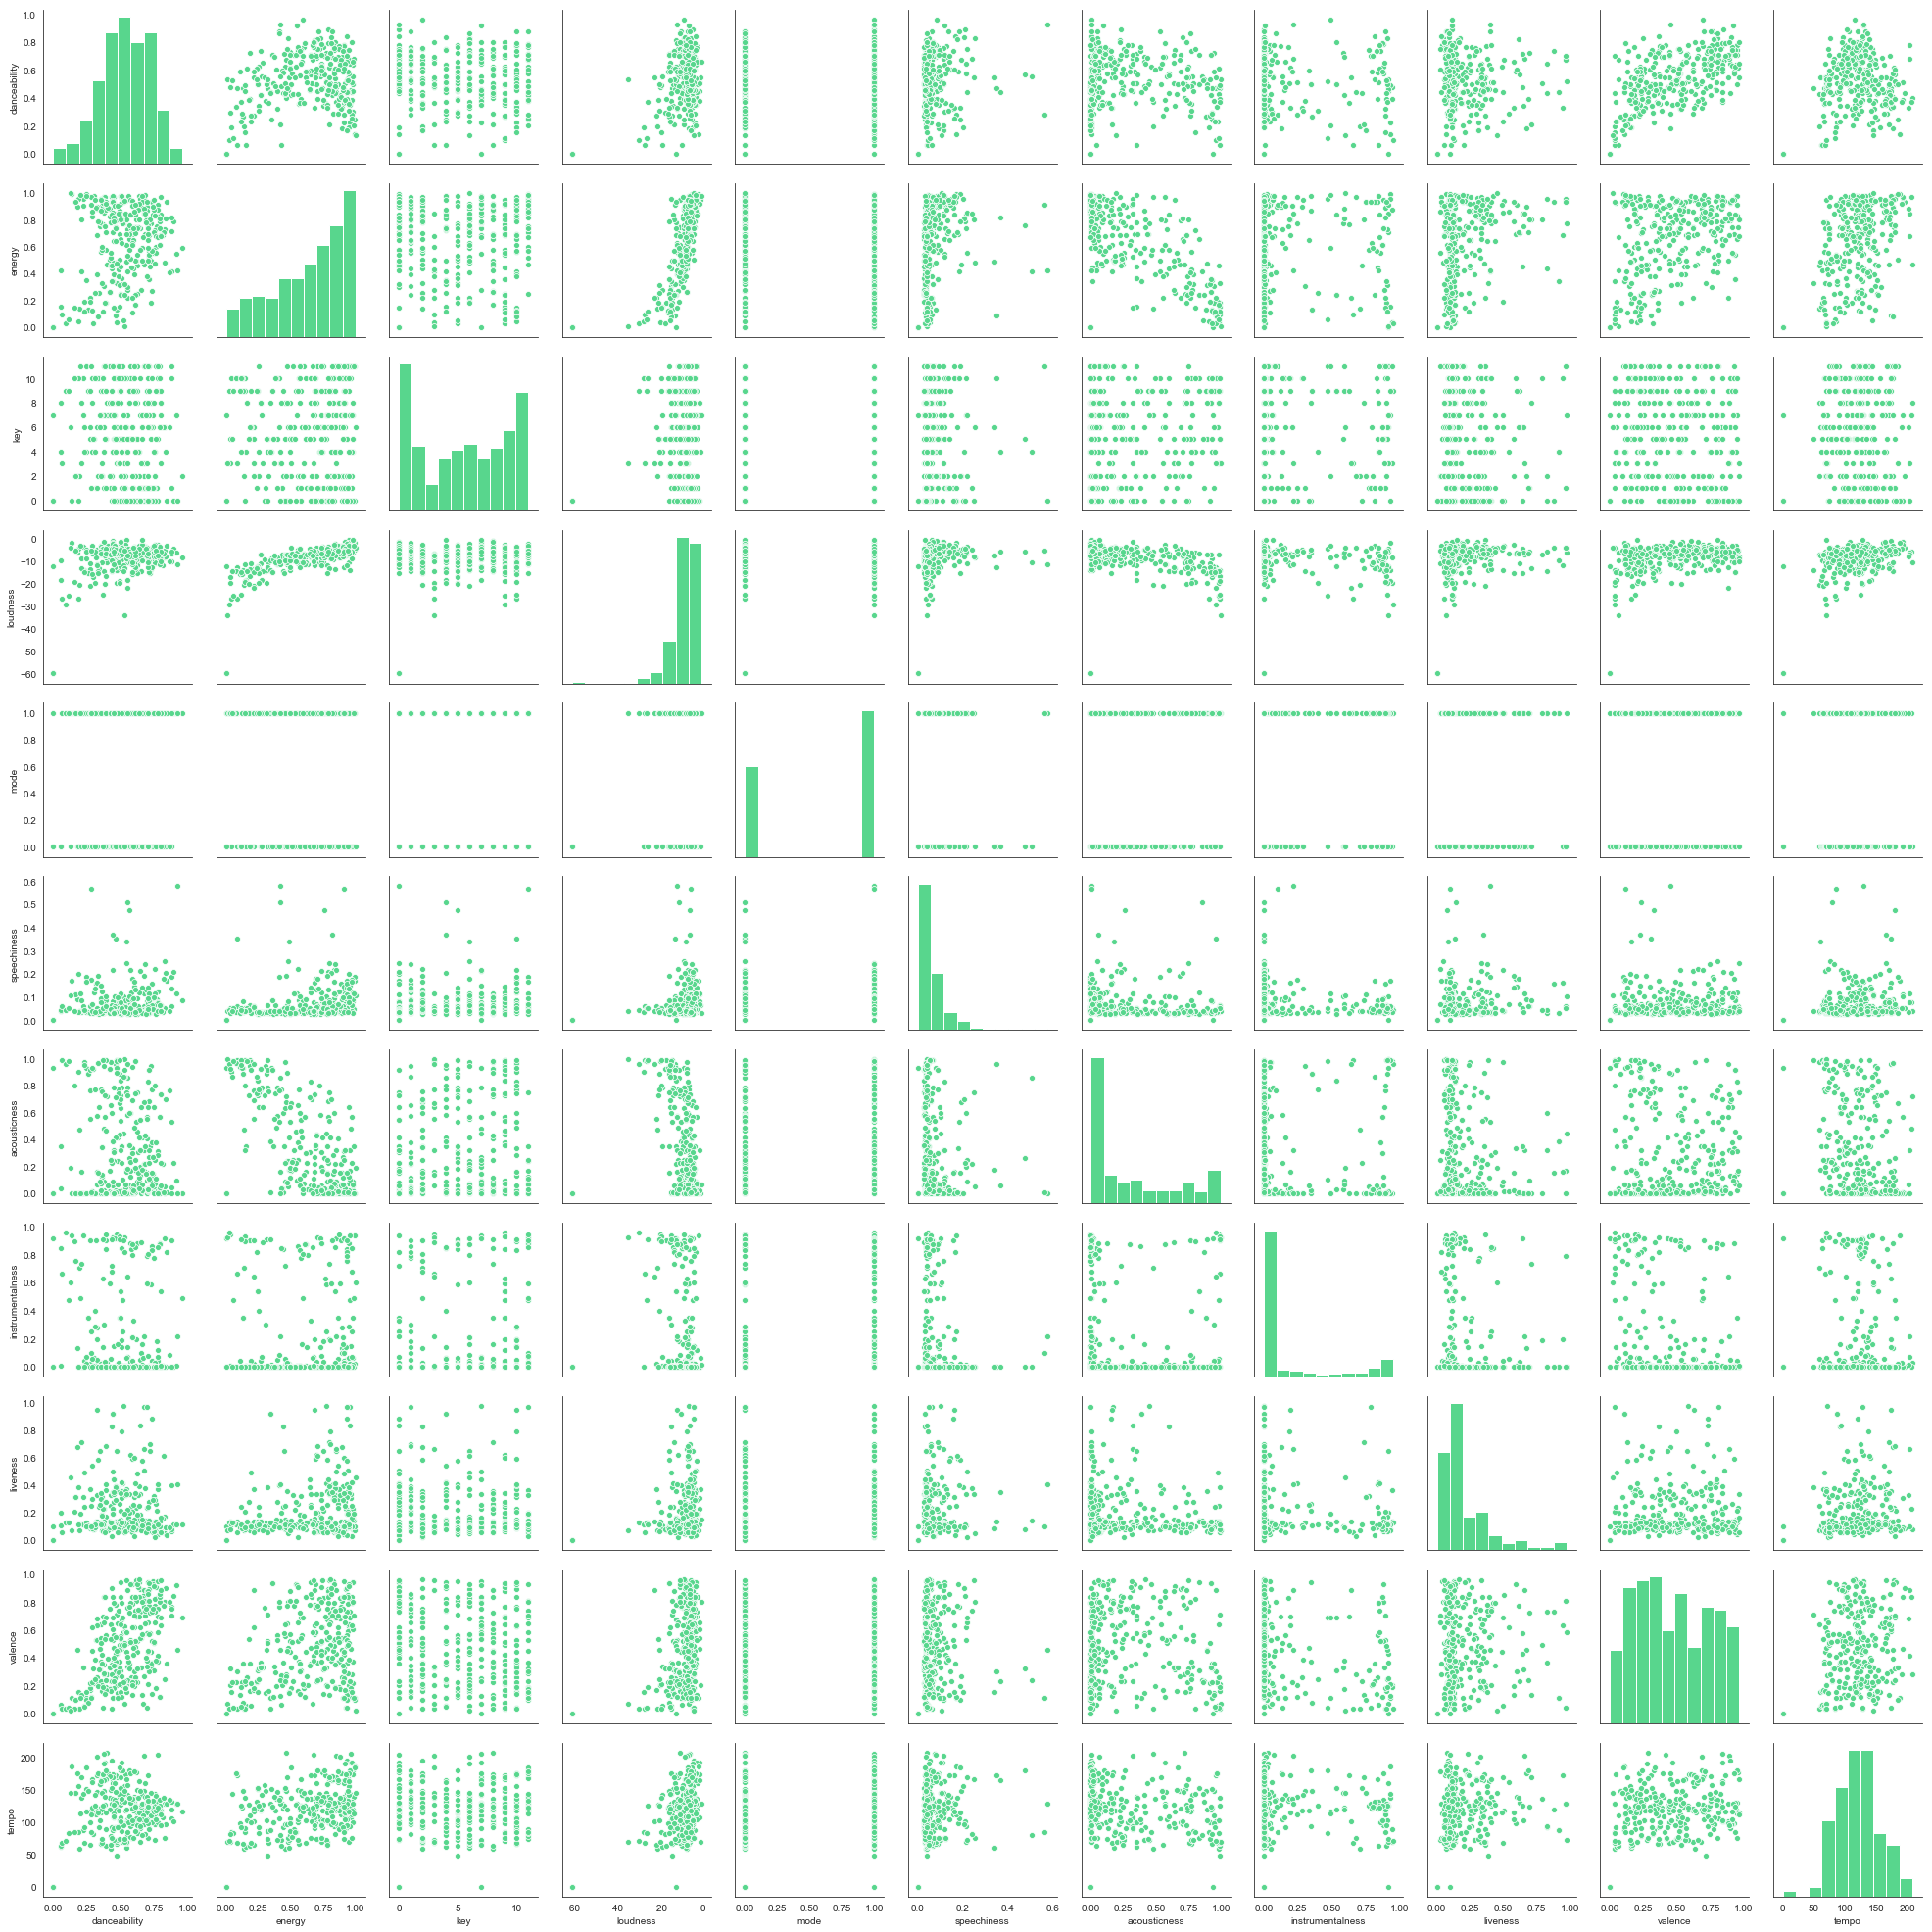

In [10]:
#Pairplot allows quick and easy plotting of all combinations of features as well as showing the distributions
#of a single feature (diagonal)
sns.pairplot(df_0.iloc[:,1:12].astype(float))

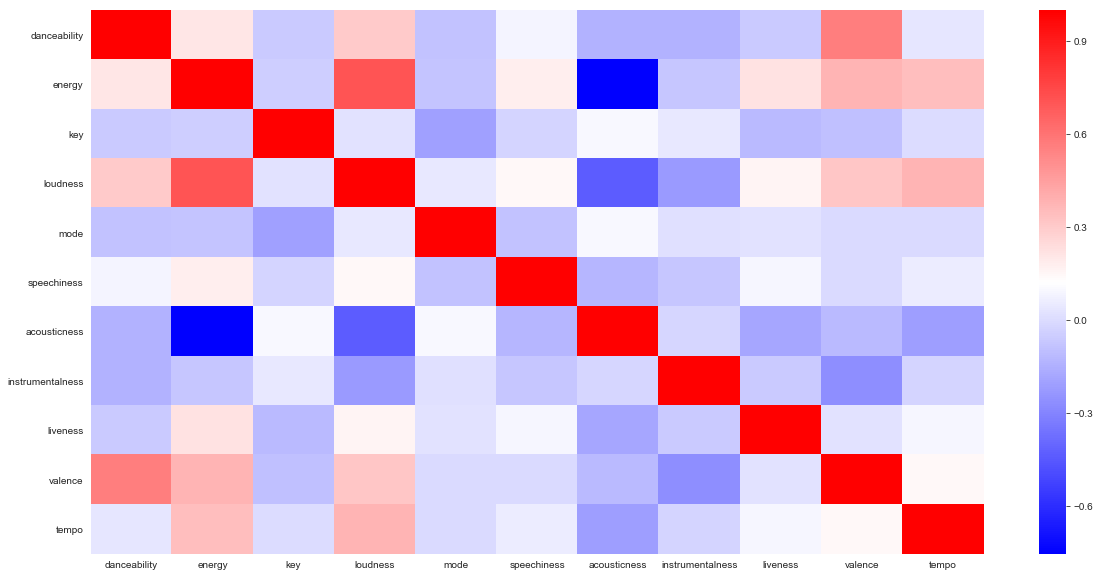

In [20]:
#The following is a correlation heatmap for user0. Correlations can be positive (red) or negative (blue)
plt.figure(figsize=(20,10))
sns.heatmap(df_0.iloc[:,1:12].astype(float).corr(),cmap="bwr")

In [21]:
#We can print the heatmap data as a table see a strong correlation between the following pairs where corr > 0.4:
# Postive : Energy and Loudness
#         : Valence and Danceability
# Negative: Energy and Acousticness
#         : Loudness and Acousticness
#defining a color function
def color_text(val):
    if val>=0.6:
        color = 'green'
    elif val>=0.3:
        color = 'blue'
    elif val<0.3 and val>-0.3:
        color = 'red'
    elif val<=-0.3:
        color = 'black'
    elif val<=-0.6:
        color = 'yellow'
    
    return 'color: %s' % color

#User 0
#print(df_0)
#df_0.style.applymap(color, subset=df_0.iloc[:,0:11].corr())
df_0.iloc[:,1:12].astype(float).corr().style.applymap(color_text)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1,0.211557,-0.0584562,0.305198,-0.084649,0.0852482,-0.142921,-0.138279,-0.0621934,0.566541,0.0383888
energy,0.211557,1,-0.0429283,0.708325,-0.0804431,0.181979,-0.755012,-0.07595,0.223279,0.378359,0.344592
key,-0.0584562,-0.0429283,1,0.0210284,-0.202922,-0.0222255,0.0987679,0.0449649,-0.115309,-0.0955393,0.00236884
loudness,0.305198,0.708325,0.0210284,1,0.045692,0.148998,-0.432976,-0.226622,0.160574,0.320838,0.378754
mode,-0.084649,-0.0804431,-0.202922,0.045692,1,-0.0844414,0.0957524,0.0166349,0.0210834,-0.00192596,-0.00649031
speechiness,0.0852482,0.181979,-0.0222255,0.148998,-0.0844414,1,-0.127181,-0.0708963,0.091595,-0.00202235,0.060701
acousticness,-0.142921,-0.755012,0.0987679,-0.432976,0.0957524,-0.127181,1,-0.0159912,-0.18258,-0.116552,-0.212434
instrumentalness,-0.138279,-0.07595,0.0449649,-0.226622,0.0166349,-0.0708963,-0.0159912,1,-0.0593834,-0.267147,-0.02266
liveness,-0.0621934,0.223279,-0.115309,0.160574,0.0210834,0.091595,-0.18258,-0.0593834,1,0.0258024,0.0900532
valence,0.566541,0.378359,-0.0955393,0.320838,-0.00192596,-0.00202235,-0.116552,-0.267147,0.0258024,1,0.145462


In [22]:
#Here we print out the larger songs database which includes several more columns
#than the user data. In particular it has info on artists and albums.
song_list.iloc[:,1:20].head(2)

,acousticness,album_id,album_name,analysis_url,artist_ids,artist_names,danceability,disc_number,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,preview_url,song_id,song_name
0,0.108,67nqYhvjDyJXGD64937Lw3,The Beach Boys' Christmas Album,https://api.spotify.com/v1/audio-analysis/5xlS...,"3oDbviiivRWhXwIE8hxkVV,03IJEZ6IynYczgge2uC4YD,...","The Beach Boys,Mark Linett,Sweet,Larry Walsh",0.602,1,118840,0.553,0.0,11,0.0512,-9.336,1,72,NaN,5xlS0QkVrSH7ssEbBgBzbM,Little Saint Nick - 1991 Remix
1,0.425,4S2ZR5njbJez1rV8DV5Vtl,Live In Japan,https://api.spotify.com/v1/audio-analysis/4gdh...,7FIoB5PHdrMZVC3q2HE5MS,George Harrison,0.611,2,211320,0.566,0.000954,9,0.878,-11.715,1,62,NaN,4gdhsYfXJoVQsWpbmh32Da,Here Comes The Sun - Live In Japan/1991/Remast...


## 4 : Create user and song instances

In [23]:
#testing
print(music_Data[:,7][0])
#print(music_Data[np.isfinite(np.float64(music_Data[:,7]))])
music_Data[0]

0.602


array(['0', '0.108', '67nqYhvjDyJXGD64937Lw3',
       "The Beach Boys' Christmas Album",
       'https://api.spotify.com/v1/audio-analysis/5xlS0QkVrSH7ssEbBgBzbM',
       '3oDbviiivRWhXwIE8hxkVV,03IJEZ6IynYczgge2uC4YD,5CAx2uZYeKOZxvasIfk9TY,507LPYi8Dm9gZdTbT3NjeD',
       'The Beach Boys,Mark Linett,Sweet,Larry Walsh', '0.602', '1',
       '118840', '0.553', '0.0', '11', '0.0512', '-9.336', '1', '72', nan,
       '5xlS0QkVrSH7ssEbBgBzbM', 'Little Saint Nick - 1991 Remix',
       '0.0328', '130.594', '4',
       'https://api.spotify.com/v1/tracks/5xlS0QkVrSH7ssEbBgBzbM', '1',
       '0.971', '1991'], dtype=object)

In [27]:
#initializing a set of user objects based on the musicFan class
m_Fans = []
songs = songs(music_Data[np.isfinite(np.float64(music_Data[:,7]))])

CREATING songs INSTANCE WITH ITEMxFEATURE MATRIX OF SHAPE: (265119, 11)
*----------------------------------------------------*


In [31]:
#This loop creates a list of m_Fan objects.
for i in range(10):
    temp = [[user_Data[x][y+1] for x in range(len(user_Data)) if i == int(user_Data[x][14])] for y in range(16) if y !=13]
    m_Fans.append(musicFan(i,temp))
    #m_Fans[i].makeScatters(songs)
    #m_Fans[i].makeHistos(songs)

CREATING musicFan INSTANCE FOR USER: 0 WITH ITEMxFEATURE MATRIX OF SHAPE: (338, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 1 WITH ITEMxFEATURE MATRIX OF SHAPE: (393, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 2 WITH ITEMxFEATURE MATRIX OF SHAPE: (410, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 3 WITH ITEMxFEATURE MATRIX OF SHAPE: (461, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 4 WITH ITEMxFEATURE MATRIX OF SHAPE: (514, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 5 WITH ITEMxFEATURE MATRIX OF SHAPE: (443, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 6 WITH ITEMxFEATURE MATRIX OF SHAPE: (331, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE 

In [32]:
data_Base.head(2)

,database_id,spotify_id,song_name,preview_url,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,5bb7ac890c27ee4c381dd69e,0bxllxzqkGNSKo8pHtZyA3,E.T.,https://p.scdn.co/mp3-preview/b010313e8fbd71b1...,0.626,0.457,8,-9.091,0,0.0339,0.0876,7.72E-05,0.0801,0.223,149.99
1,5bb7ac890c27ee4c381dd69f,362LzQDbfNdZDuv37BIEkG,Song For Zula - Live From Spotify London,https://p.scdn.co/mp3-preview/f85a3283dc9d614c...,0.441,0.344,4,-9.799,1,0.0299,0.386,0.000277,0.917,0.111,87.588


In [33]:
for i in range(10):
    m_Fans[i].getFromData(data_Base)

GETTING ADDITONAL DATA FROM DB FILE FOR USER: 0
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 1
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 0
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 1
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 0
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 1
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 0
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 1
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 2
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 3
*------------------------

## 5 : Training and testing various models: cSim, KNN, Logistic Regression, KMeans

### Cosine Similarity

In [29]:
#this test the models for each user.
musicFan.train_Test(m_Fans,cSim=True)

INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the chance of cosineSimilarity recommendation being better than random song picks is:

For: 0 : 0.67
For: 1 : 0.57
For: 2 : 0.77
For: 3 : 0.82
For: 4 : 0.41
For: 5 : 0.86
For: 6 : 0.57
For: 7 : 0.51
For: 8 : 0.48
For: 9 : 0.98
*----------------------------------------------------*
MODEL TESTING COMPLETE


### KNN

In [30]:
musicFan.train_Test(m_Fans,KNN=True)

INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the average accuracy of KNN recommendation is:

For: 0 : 0.6274509803921574
For: 1 : 0.5292372881355936
For: 2 : 0.6813821138211378
For: 3 : 0.7949640287769781
For: 4 : 0.757483870967742
For: 5 : 0.5657894736842103
For: 6 : 0.7019
For: 7 : 0.5543209876543209
For: 8 : 0.5044444444444445
For: 9 : 0.7187826086956526
*----------------------------------------------------*
MODEL TESTING COMPLETE


### Logistic Regression

In [31]:
musicFan.train_Test(m_Fans,logistic=True)

INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the average accuracy of logistic regression recommendation is:

For: 0 : 0.678529411764706
For: 1 : 0.5804237288135593
For: 2 : 0.7234146341463417
For: 3 : 0.8199999999999993
For: 4 : 0.7897419354838712
For: 5 : 0.5944360902255641
For: 6 : 0.7407999999999997
For: 7 : 0.5967901234567902
For: 8 : 0.5402777777777782
For: 9 : 0.7296521739130436
*----------------------------------------------------*
MODEL TESTING COMPLETE


### KMeans

In [32]:
musicFan.train_Test(m_Fans,KM=True)

INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the average accuracy of Kmeans recommendation is:

For: 0 : 0.507843137254902
For: 1 : 0.49237288135593216
For: 2 : 0.5130081300813009
For: 3 : 0.539568345323741
For: 4 : 0.5
For: 5 : 0.5075187969924811
For: 6 : 0.515
For: 7 : 0.5246913580246914
For: 8 : 0.512962962962963
For: 9 : 0.5226086956521739
*----------------------------------------------------*
MODEL TESTING COMPLETE


In [33]:
#running cSim model and outputting recommendation:
for i in range(5):
    m_Fans[i].cosineSimilarity(songs,outputRec=True)

(109, 8)
(265119, 8)
Recommended songs for user: 0 .
ID [('7qKJrEYAO22JNHSrgK43lg', 63), ('6CAdgnhKyJYtpJiVxTdDfT', 63), ('1XzeGTpwZPefPTI81Fde4B', 60), ('7D5qCBnl1Qab2qndKHXcLG', 60), ('7KWRfJkrBghJDSphN1taut', 60), ('2Gyuge3kQa0KBJ5EsMhYNJ', 57), ('4HO9PDJLT2j2vRsIkkIPur', 57), ('2ZApTsveC0XnZDPfpOgnx6', 54), ('7AARXbifhQ0g7DdUxDsvON', 54), ('2Qi2RbXilMTewXIu6QFamP', 54)]
(165, 8)
(265119, 8)
Recommended songs for user: 1 .
ID [('5H9aMQdVgwkuHAYUyHJ3zX', 99), ('6MEw0tLXlyX3Ydwh6cVaTS', 93), ('7qKJrEYAO22JNHSrgK43lg', 93), ('0leoH2BvQMQvj1JofWSP4Q', 90), ('4gXkajxmaVyOeZAVwzKSlL', 87), ('4Svrybqf1k5htl3pHQNCQW', 78), ('2w4kDTXOirNIKvpmONBdH6', 76), ('44RuG8ZT3NoRGHnrNNkvRa', 75), ('4lHSiOcWSMm2jSgla0qbZ0', 72), ('5L7jLTNkklV0GNk0P289TH', 72)]
(113, 8)
(265119, 8)
Recommended songs for user: 2 .
ID [('0leoH2BvQMQvj1JofWSP4Q', 84), ('5H9aMQdVgwkuHAYUyHJ3zX', 72), ('44RuG8ZT3NoRGHnrNNkvRa', 72), ('7qKJrEYAO22JNHSrgK43lg', 69), ('2m2x2zvpzbyvykadQlW9pi', 69), ('36vIoT0B7PQIEOb4uvuULB', 69

MemoryError: 